In [1]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, BatchNormalization, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, BatchNormalization, Flatten, Dense, GlobalAveragePooling2D


2025-08-10 13:19:23.221454: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754831963.575131      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754831963.683303      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
DATASET_DIR = '/kaggle/input/asl-dataset/asl_dataset/dataset'
IMG_SIZE = 64

In [3]:
def load_images_from_folder(folder_path):
    images, labels = [], []
    class_names = sorted(os.listdir(folder_path))
    label_map = {name: idx for idx, name in enumerate(class_names)}

    for label in class_names:
        class_folder = os.path.join(folder_path, label)
        if not os.path.isdir(class_folder):
            continue
        for file in os.listdir(class_folder):
            img_path = os.path.join(class_folder, file)
            try:
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
                images.append(img)
                labels.append(label_map[label])
            except:
                print(f"Error reading: {img_path}")

    return np.array(images), np.array(labels), label_map


In [4]:
X, y, label_map = load_images_from_folder(DATASET_DIR)


In [5]:
X = X / 255.0
X = X.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y_cat = to_categorical(y)

In [6]:
X_train, X_val, y_train, y_val = train_test_split(X, y_cat, test_size=0.2)


In [7]:
model = Sequential([
    # Block 1
    Conv2D(32, (3,3), activation='relu', padding='same', 
           kernel_regularizer=l2(1e-4), input_shape=(IMG_SIZE, IMG_SIZE, 1)),
    BatchNormalization(),
    Conv2D(32, (3,3), activation='relu', padding='same', kernel_regularizer=l2(1e-4)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),

    # Block 2
    Conv2D(64, (3,3), activation='relu', padding='same', kernel_regularizer=l2(1e-4)),
    BatchNormalization(),
    Conv2D(64, (3,3), activation='relu', padding='same', kernel_regularizer=l2(1e-4)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.3),

    # Block 3
    Conv2D(128, (3,3), activation='relu', padding='same', kernel_regularizer=l2(1e-4)),
    BatchNormalization(),
    Conv2D(128, (3,3), activation='relu', padding='same', kernel_regularizer=l2(1e-4)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.4),

    # Block 4 (extra for deeper features)
    Conv2D(256, (3,3), activation='relu', padding='same', kernel_regularizer=l2(1e-4)),
    BatchNormalization(),
    Conv2D(256, (3,3), activation='relu', padding='same', kernel_regularizer=l2(1e-4)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.5),

    # Global Average Pooling instead of Flatten
    GlobalAveragePooling2D(),
    
    # Dense layers
    Dense(256, activation='relu', kernel_regularizer=l2(1e-4)),
    BatchNormalization(),
    Dropout(0.5),
    
    Dense(len(label_map), activation='softmax')
])

# Compile
model.compile(optimizer=Adam(learning_rate=1e-4), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1754832860.533052      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1754832860.533776      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,252,359 (4.78 MB)

 Trainable params: 1,249,927 (4.77 MB)

 Non-trainable params: 2,432 (9.50 KB)

In [8]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=16)

# Save model & label map
model.save('model/sign_model.h5')
np.save('model/label_map.npy', label_map)



Epoch 1/16


I0000 00:00:1754832875.315583     100 service.cc:148] XLA service 0x7b9ea400d9a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1754832875.316889     100 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1754832875.316909     100 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1754832876.403100     100 cuda_dnn.cc:529] Loaded cuDNN version 90300


   6/2190 ━━━━━━━━━━━━━━━━━━━━ 53s 24ms/step - accuracy: 0.0507 - loss: 4.9278  

I0000 00:00:1754832887.014420     100 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2190/2190 ━━━━━━━━━━━━━━━━━━━━ 69s 22ms/step - accuracy: 0.1486 - loss: 3.6753 - val_accuracy: 0.6510 - val_loss: 1.2549
Epoch 2/16
2190/2190 ━━━━━━━━━━━━━━━━━━━━ 36s 16ms/step - accuracy: 0.6203 - loss: 1.3044 - val_accuracy: 0.9255 - val_loss: 0.3517
Epoch 3/16
2190/2190 ━━━━━━━━━━━━━━━━━━━━ 37s 17ms/step - accuracy: 0.8566 - loss: 0.5595 - val_accuracy: 0.9748 - val_loss: 0.1871
Epoch 4/16
2190/2190 ━━━━━━━━━━━━━━━━━━━━ 38s 17ms/step - accuracy: 0.9367 - loss: 0.3143 - val_accuracy: 0.9906 - val_loss: 0.1389
Epoch 5/16
2190/2190 ━━━━━━━━━━━━━━━━━━━━ 38s 17ms/step - accuracy: 0.9679 - loss: 0.2137 - val_accuracy: 0.9959 - val_loss: 0.1211
Epoch 6/16
2190/2190 ━━━━━━━━━━━━━━━━━━━━ 38s 17ms/step - accuracy: 0.9794 - loss: 0.1738 - val_accuracy: 0.9979 - val_loss: 0.1120
Epoch 7/16
2190/2190 ━━━━━━━━━━━━━━━━━━━━ 38s 17ms/step - accuracy: 0.9866 - loss: 0.1498 - val_accuracy: 0.9976 - val_loss: 0.1095
Epoch 8/16
2190/2190 ━━━━━━━━━━━━━━━━━━━━ 38s 17ms/step - accuracy: 0.9898 - loss: 0.13

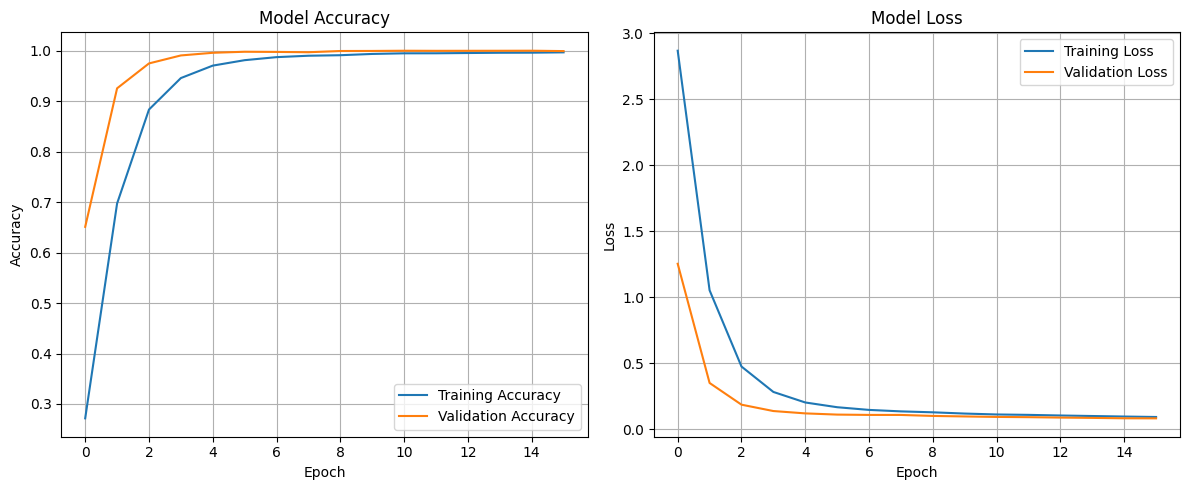

In [9]:
import matplotlib.pyplot as plt

# Plot accuracy and validation loss
plt.figure(figsize=(12,5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


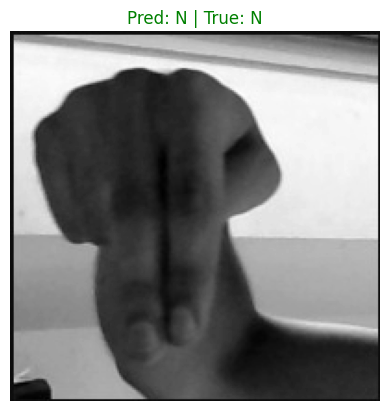

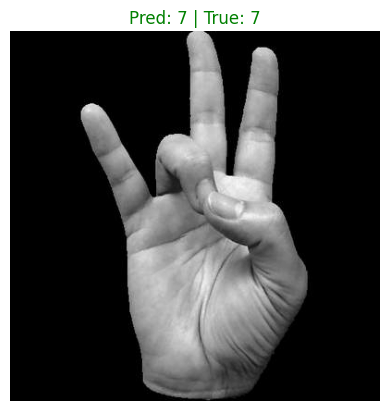

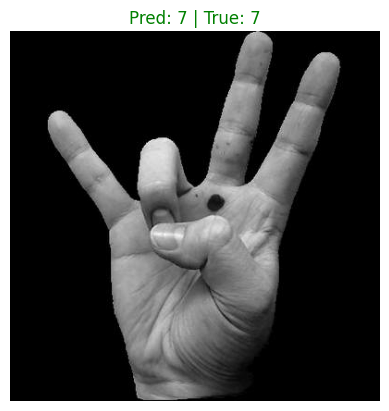

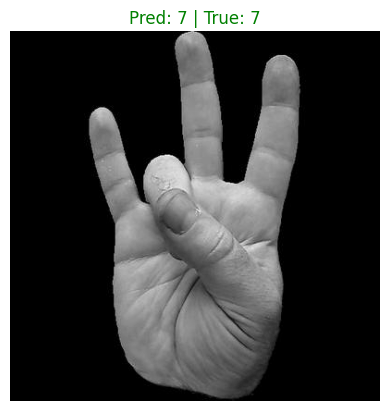

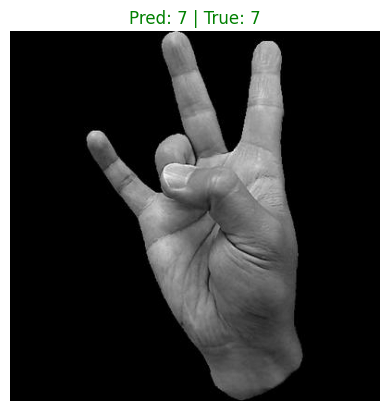

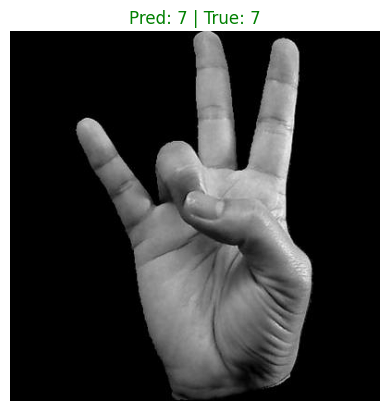

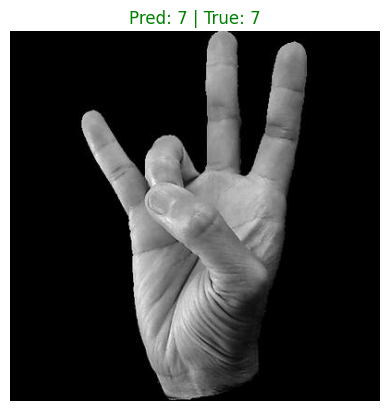

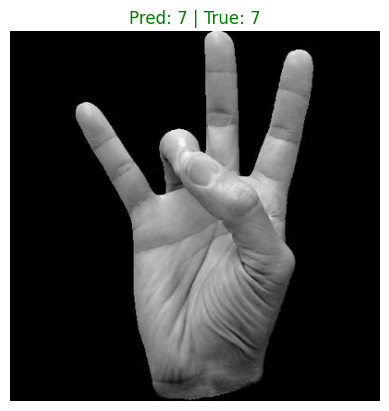

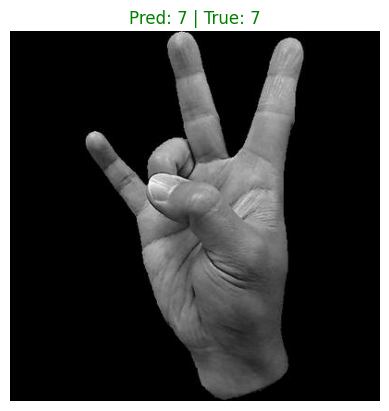

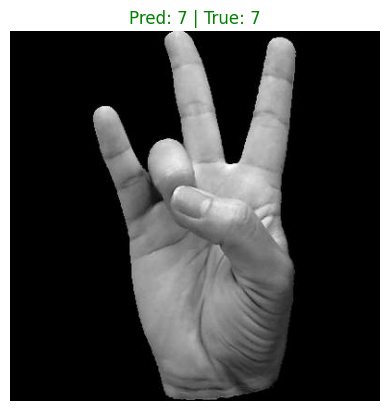

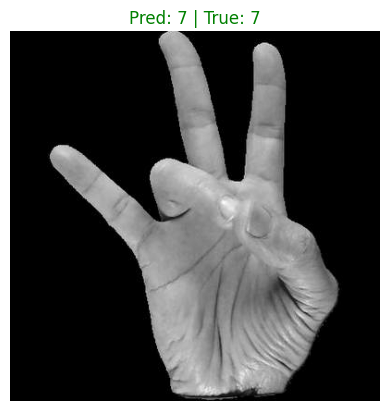

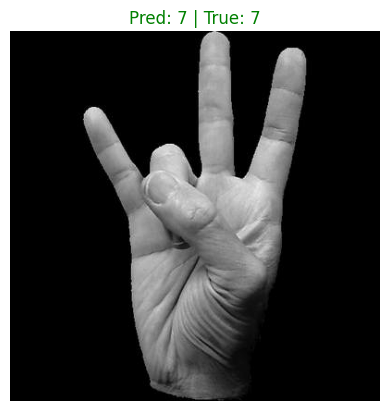

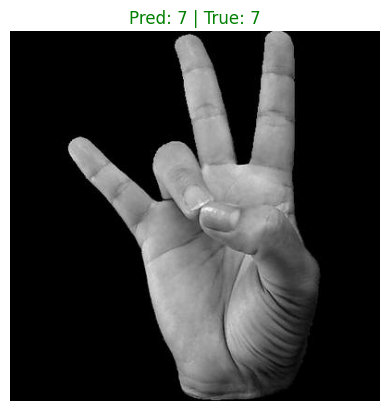

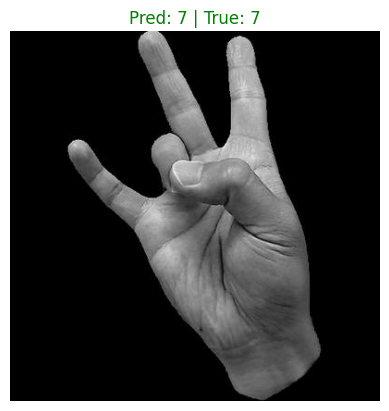

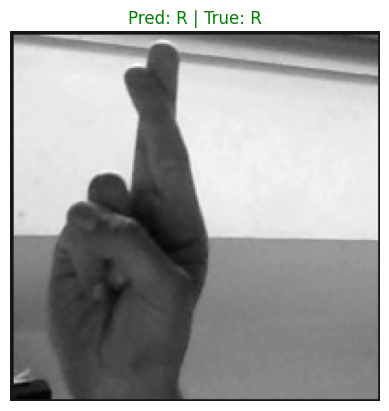

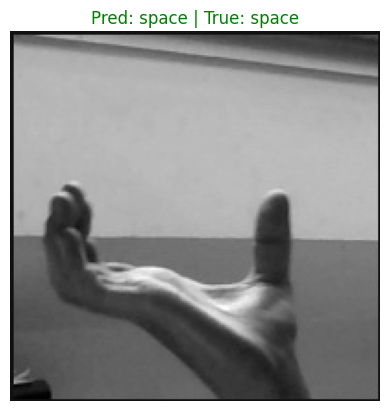

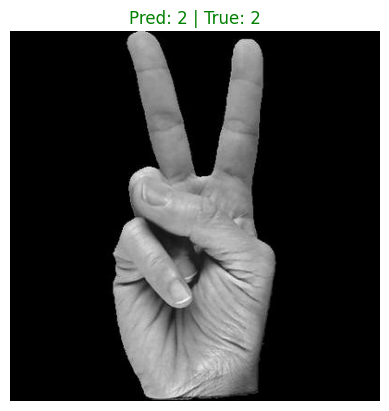

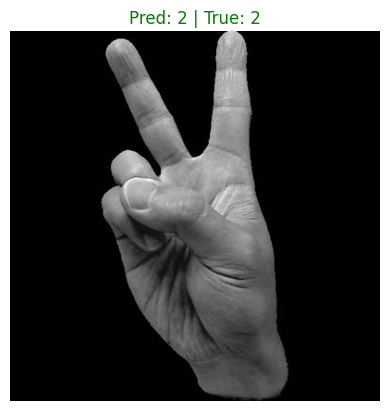

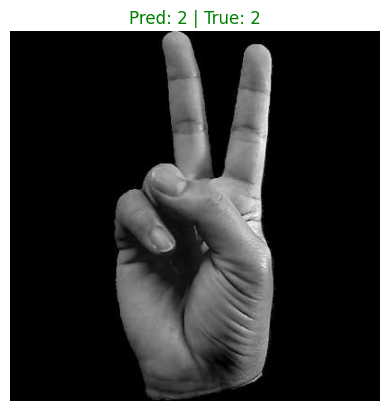

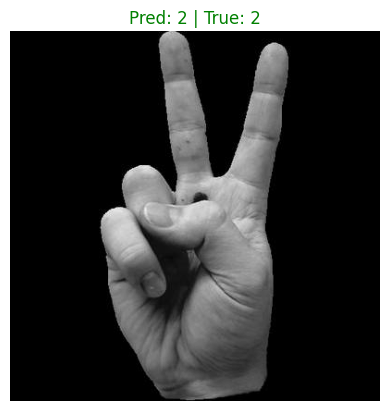

Test Accuracy: 99.37% on 159 images.


In [11]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

MODEL_PATH = '/kaggle/working/model/sign_model.h5'
LABEL_MAP_PATH = '/kaggle/working/model/label_map.npy'
TEST_DIR = '/kaggle/input/asl-dataset/asl_dataset/dataset_test'
IMG_SIZE = 64

# Load model and label map
model = load_model(MODEL_PATH)
label_map = np.load(LABEL_MAP_PATH, allow_pickle=True).item()
idx_to_label = {v: k for k, v in label_map.items()}

correct = 0
total = 0

# Limit images shown for speed
max_display = 20
displayed = 0

for label in os.listdir(TEST_DIR):
    label_folder = os.path.join(TEST_DIR, label)
    if not os.path.isdir(label_folder):
        continue

    for file in os.listdir(label_folder):
        img_path = os.path.join(label_folder, file)
        try:
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            img_normalized = img_resized / 255.0
            img_input = img_normalized.reshape(1, IMG_SIZE, IMG_SIZE, 1)

            prediction = model.predict(img_input, verbose=0)
            predicted_label = idx_to_label[np.argmax(prediction)]

            # Accuracy tracking
            if predicted_label == label:
                correct += 1
            total += 1

            # Show only limited number for performance
            if displayed < max_display:
                plt.imshow(img, cmap='gray')
                color = 'green' if predicted_label == label else 'red'
                plt.title(f"Pred: {predicted_label} | True: {label}", color=color)
                plt.axis('off')
                plt.show()
                displayed += 1

        except Exception as e:
            print(f"Skipping: {img_path} ({e})")

accuracy = (correct / total) * 100 if total > 0 else 0
print(f"Test Accuracy: {accuracy:.2f}% on {total} images.")


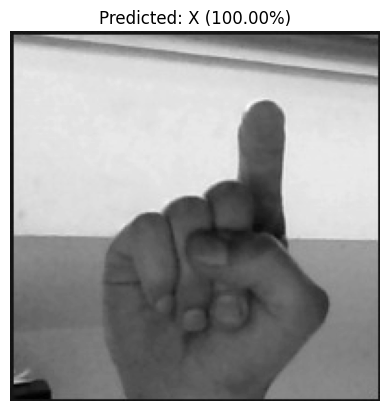

Prediction: X (100.00%)


In [20]:

import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Paths
MODEL_PATH = '/kaggle/working/model/sign_model.h5'
LABEL_MAP_PATH = '/kaggle/working/model/label_map.npy'
IMG_SIZE = 64

# Load model and label map
model = load_model(MODEL_PATH)
label_map = np.load(LABEL_MAP_PATH, allow_pickle=True).item()
idx_to_label = {v: k for k, v in label_map.items()}

def predict_image(image_path):
    # Read and preprocess image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Image not found: {image_path}")
        
    img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img_normalized = img_resized / 255.0
    img_input = img_normalized.reshape(1, IMG_SIZE, IMG_SIZE, 1)

    # Predict
    prediction = model.predict(img_input, verbose=0)
    predicted_label = idx_to_label[np.argmax(prediction)]
    confidence = np.max(prediction) * 100

    # Display
    plt.imshow(img, cmap='gray')
    plt.title(f"Predicted: {predicted_label} ({confidence:.2f}%)")
    plt.axis('off')
    plt.show()

    return predicted_label, confidence

# Example usage — change the path to your image
image_path = '/kaggle/input/asl-dataset/asl_dataset/dataset_test/X/X_test.jpg'
label, conf = predict_image(image_path)
print(f"Prediction: {label} ({conf:.2f}%)")
